In [255]:
# primero voy a copiar el codigo de clase para lograr optimizar un primer portafolio

In [256]:
#!pip install pyportfolioopt
#!pip install cvxpy
#!pip install yfinance


In [1]:
# Importo librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
from pypfopt import expected_returns
from pypfopt import risk_models
import cvxpy as cp
import random
import warnings


In [2]:

# ignorando errores de depreciacion de funcionalidades

warnings.filterwarnings('ignore', category=DeprecationWarning)

In [3]:

# haciendo que numpy represente correctamente los numeros
np.set_printoptions(suppress=True, formatter={'float_kind': '{:.6f}'.format})
np.set_printoptions(threshold=np.inf)


In [4]:
# Defino algunas funciones para emprolijar los datos
def format_df(df):
    # Porque se descarga un dataframe multiindice en las columnas
    df.columns = [ '_'.join(x) for x in df.columns ]
    df = df.loc[:,df.columns.str.endswith('_Close')]
    df.columns = df.columns.str.replace(r'_Close$', '')
    return df

In [5]:
# Descargo algunos tickers de Yahoo Finance, y miro los primeros 5 registros


tickers = ['NVDA', 'AAPL', 'MSFT', 'AMZN', 'GOOGL', 'GOOG', 'META', 'BRK-B', 'TSLA', 'V', 'JNJ', 'JPM', 'XOM', 'PG', 'MA', 'CVX', 'BA', 'GM', 'CAT', 'AA', 'FDX', 'GLW', 
            'HD', 'PFE', 'BAC', 'DIS', 'CSCO', 'PEP', 'MRK', 'INTC', 'KO', 'ABBV', 'ORCL', 'CMCSA', 'TMO', 'AVGO', 'UNH', 'WMT', 'T', 'C', 'F', 'DE', 'GIS', 'GS']


start_date = '2013-06-01'
end_date = '2023-6-30'  # dt.datetime.now()

asset_data_raw = yf.download(
    tickers = tickers,
    interval = '1mo',
    start = start_date,
    end = end_date,
    group_by = 'ticker',
    auto_adjust = True,
    prepost = True,
    threads = True,
    )



#asset_data = format_df(asset_data_raw.copy())

#asset_data.columns = tickers


#asset_data.head(10)

#asset_data_raw.head()

asset_data = pd.DataFrame({
    ticker: asset_data_raw[ticker]['Close'] for ticker in tickers
})

asset_data.tail()

[*********************100%***********************]  44 of 44 completed


,NVDA,AAPL,MSFT,AMZN,GOOGL,GOOG,META,BRK-B,TSLA,V,...,TMO,AVGO,UNH,WMT,T,C,F,DE,GIS,GS
Date,,,,,,,,,,,,,,,,,,,,,
2023-02-01,23.200724,145.875992,245.392838,94.230003,89.837547,90.078789,174.414871,305.179993,205.710007,216.551971,...,539.248474,57.487892,463.423523,46.214352,16.927309,46.712959,10.208574,409.082733,74.947990,332.785828
2023-03-01,27.758722,163.433105,284.355499,103.290001,103.473785,103.745224,211.303787,308.769989,207.460007,222.421707,...,573.697998,62.058556,460.161682,47.944183,17.231661,43.637276,11.328667,402.876892,80.556610,309.562286
2023-04-01,27.735453,168.170593,303.056091,105.449997,107.074860,107.954887,239.598602,328.549988,164.309998,229.593704,...,552.684875,61.039879,480.855438,49.289925,15.817323,43.804790,10.681314,370.015442,83.544724,327.343475
2023-05-01,37.815529,175.673248,323.897003,120.580002,122.566513,123.067772,263.925323,321.079987,203.929993,218.051392,...,506.430176,78.719521,476.116119,47.951328,14.280424,41.697731,10.923958,338.653931,79.826324,308.719238
2023-06-01,42.281345,192.510468,336.615051,130.360001,119.404335,120.673645,286.118530,341.000000,261.769989,234.736465,...,519.667175,84.513672,469.666901,51.512360,14.480152,43.315968,13.773290,396.610168,72.750473,309.763855


In [6]:
asset_data.isna().sum()

NVDA     0
AAPL     0
MSFT     0
AMZN     0
GOOGL    0
GOOG     0
META     0
BRK-B    0
TSLA     0
V        0
JNJ      0
JPM      0
XOM      0
PG       0
MA       0
CVX      0
BA       0
GM       0
CAT      0
AA       0
FDX      0
GLW      0
HD       0
PFE      0
BAC      0
DIS      0
CSCO     0
PEP      0
MRK      0
INTC     0
KO       0
ABBV     0
ORCL     0
CMCSA    0
TMO      0
AVGO     0
UNH      0
WMT      0
T        0
C        0
F        0
DE       0
GIS      0
GS       0
dtype: int64

In [7]:
# Defino una funcion para obtener el riesgo y rendimiento deu n portafolio:
# Calculamos volatilidad y retorno de un portafolio
def portfolio_metrics(weights, mean_returns, cov_matrix):
    ret = weights @ mean_returns.values
    std = np.sqrt(weights @ (cov_matrix.values @ weights))   # np.dot(np.dot(weights, cov_matrix.values),weights)
    return ret, std

# Defino una funcion para generar portafolios aleatorios, dado un vector de medias y una matriz de covarianzas
def random_portfolios(num_port, mean_returns, cov_matrix):
    metrics = np.zeros((2,num_port))
    weights_matrix = []

    for i in range(num_port):
        weights = np.random.random(len(mean_returns.values))
        weights /= np.sum(weights)
        weights_matrix.append(weights)

        port_mu, port_std = portfolio_metrics(weights, mean_returns, cov_matrix)
        metrics[0,i] = port_mu
        metrics[1,i] = port_std
    return metrics, weights_matrix


In [8]:
def present_solution(solution, portfolio_type = 'Markowitz'):
    if portfolio_type == 'Markowitz':
        print(f"Portfolio Return: \t{solution['portfolio_return']:.4f} \t Minimum Admissible Return: {solution['portfolio_min_required_return']}\nPortfolio Risk: \t{solution['portfolio_risk']:.4f}\nPositions Allowed: \t{solution['positions_allowed']}")
        display(solution["weights"])
    if portfolio_type == 'Sharpe':
        print(f"Portfolio Return: \t\t\t{solution['portfolio_return']:.4f}\nPortfolio Risk: \t\t\t{solution['portfolio_risk']:.4f}\nPortfolio Sharpe Ratio: \t{solution['portfolio_sharpe']:.4f}\nRisk Free Rate: \t\t\t{solution['risk_free_rate']:.4}\nPositions Allowed: \t\t\t{solution['positions_allowed']}")
        display(solution["weights"])

In [9]:
def optimize_sharpe_portfolio(mean_returns_vec, covariance_matrix, risk_free_rate = 0, allow_short=False, weight_truncation_threshold = 1e-06):
    '''

    :param mean_returns_vec: pd.DataFrame with asset returns as a (n,1) pd.Series, with index equal to asset names.
    :param covariance_matrix: pd.DataFrame with asset covariances as an (n,n) with row indexes  and column names equal to asset names in the same order.
    :param base_portfolio_return: Minimum admissible portfolio return threshold. It is mu_p in the restriction: w.T x mu >= mu_p
    :param weight_truncation_threshold: Threshold below which weight is forced to zero. This is to avoid (10^-23 weigths). Currently set to 10^(-6) by default.
    :return: dictionary containing (i) optimal risk value, (ii) portfolio return, (iii) dataframe with optimal composition indexed by asset
    '''

    mu = mean_returns_vec.values
    Sigma = covariance_matrix.values
    n = len(mu)
    positions_allowed = ''

    wp = cp.Variable(n) # w transformado
    k = cp.Variable(1)

    # Tasa libre de riesgo
    rf = cp.Parameter(nonneg=True)
    rf.value = risk_free_rate
    u = np.ones((1, mu.shape[1])) * rf # En forma vectorial: Un vector lleno de rf

    # Funcional
    transformed_risk = cp.quad_form(wp, Sigma)   # wT Sigma w


    # Si pido minima varianza global, entonces es el problema de antes
    if allow_short:
        positions_allowed = 'Long-Short'
        constraints = [(mu-u).T @ wp == 1,
                       k >= 0,
                       cp.sum(wp) == k] # wp >= 0.01*k, #para que el peso minimo sea 0.01%
    else:
        positions_allowed = 'Long Only'
        constraints = [(mu-u).T @ wp == 1,
                       wp >= 0,   # long only
                       k >= 0,
                       cp.sum(wp) == k] # wp >= 0.01*k, #para que el peso minimo sea 0.01%

    prob = cp.Problem(cp.Minimize(transformed_risk), constraints)
    prob.solve()

    # Recupero weights del problema original (revierto las transformaciones que me llevaron a resolver el problema de Sharpe como un problema como el de antes)
    w = np.array(wp.value / k.value, ndmin=2).reshape(-1,1)
    ret = (w.T @ mean_returns_vec.values)[0,0]
    risk = (w.T @ Sigma @ w)[0,0]
    opt_sharpe = (ret - rf.value) / np.sqrt(risk)

    # Calculo el riesgo y rendimiento, en las variables sin transformar, para reportarlo


    # Una vez que resuelvo el problema, guardo las variables relevantes en un diccionario por comodidad.
    return {"portfolio_risk": np.sqrt(risk),  # Devuelve la volatilidad directamente
            "portfolio_return":ret,
            "portfolio_sharpe": opt_sharpe,
            "positions_allowed": positions_allowed,
            "risk_free_rate":risk_free_rate,
            "weights": pd.DataFrame(w, index = mean_returns_vec.index, columns = ["Portfolio Composition"]).apply(lambda r: np.where(np.abs(r) <= weight_truncation_threshold,0,r))}


In [10]:
# ya teniendo claro como optimizar un portafolio voy a crear multiples conjuntos de pocos activos

In [11]:

# Suponiendo que tu DataFrame se llama 'df'
columns = asset_data.columns.tolist()  # Obtener los nombres de las columnas del DataFrame

# Generar 40 combinaciones aleatorias de 7 activos
num_combinations = 50
assets_per_combination = 7

random_combinations = [random.sample(columns, assets_per_combination) for _ in range(num_combinations)]

# Mostrar las combinaciones generadas
for i, combination in enumerate(random_combinations, start=1):
    print(f"{i}: {combination}")


1: ['PEP', 'XOM', 'META', 'KO', 'NVDA', 'MSFT', 'JNJ']
2: ['PEP', 'DE', 'GM', 'XOM', 'V', 'KO', 'CAT']
3: ['DE', 'HD', 'BA', 'GLW', 'INTC', 'JPM', 'FDX']
4: ['F', 'T', 'AAPL', 'META', 'MRK', 'PEP', 'TMO']
5: ['FDX', 'WMT', 'CSCO', 'DIS', 'TSLA', 'CVX', 'T']
6: ['ORCL', 'AA', 'INTC', 'UNH', 'AMZN', 'META', 'PG']
7: ['F', 'XOM', 'CMCSA', 'TSLA', 'MA', 'KO', 'JNJ']
8: ['AA', 'GIS', 'DE', 'BA', 'GOOG', 'F', 'MSFT']
9: ['CSCO', 'GIS', 'WMT', 'CVX', 'CAT', 'FDX', 'PG']
10: ['BAC', 'PEP', 'XOM', 'CAT', 'KO', 'TSLA', 'CMCSA']
11: ['AVGO', 'ORCL', 'PEP', 'XOM', 'JPM', 'AMZN', 'T']
12: ['FDX', 'INTC', 'CVX', 'DIS', 'GM', 'ORCL', 'C']
13: ['CMCSA', 'F', 'CSCO', 'PFE', 'GOOG', 'T', 'AAPL']
14: ['GM', 'MA', 'GOOG', 'HD', 'UNH', 'V', 'AMZN']
15: ['TSLA', 'PG', 'GM', 'CAT', 'F', 'GOOG', 'GLW']
16: ['AAPL', 'DE', 'ORCL', 'HD', 'ABBV', 'JPM', 'T']
17: ['GM', 'JNJ', 'UNH', 'PEP', 'AAPL', 'AMZN', 'F']
18: ['GIS', 'PFE', 'CMCSA', 'KO', 'HD', 'AVGO', 'GS']
19: ['FDX', 'JPM', 'GOOGL', 'C', 'META', 'AAPL', '

In [12]:
# creando una funcion que permita tomar un dataset entero y crear un portafolio con los datos de los ultimos cinco anios

In [25]:

def sr(asset_data):
    
    months = 70
    
    asset_data = asset_data.reset_index(drop=True)
    asset_data.index = range(len(asset_data))
    
    # obteniendo nombres de columnas
    column_names = asset_data.columns
    
    # creando la tabla que va a devolver la funcion
    dff = pd.DataFrame(columns=column_names, index=range(len(asset_data)))
    

    
    # bucle
    for i in range(months, len(asset_data)):
        
        # Tomar las primeras x filas a partir del indice en el que esta
        subset = asset_data.iloc[i - months:i]

            
        mean_returns_annualized = expected_returns.mean_historical_return(subset[column_names], returns_data=False, compounding=True, frequency=12, log_returns=False)
        covariance_matrix_annualized = risk_models.sample_cov(subset[column_names], frequency=12, returns_data=False, log_returns=False)

        mean_returns_annualized = pd.DataFrame(mean_returns_annualized.to_numpy().reshape(-1,1),
                                        index = mean_returns_annualized.index,
                                        columns = ['Mean Return Annualized'])


        
        # Simmulo portafolios aleatorios y almaceno sus metricas de desempenio y sus composiciones (por separeado)

        # Número de portafolios
        np.random.seed(123)
        num_sim_portfolios = int(1e5)

        # Simulacion
        metrics, weights_matrix = random_portfolios(num_port = num_sim_portfolios,
                                                    mean_returns = mean_returns_annualized,
                                                    cov_matrix = covariance_matrix_annualized)


        # Busco el portafolio de maximo ratio de Sharpe

        mu = mean_returns_annualized.values
        Sigma = covariance_matrix_annualized.values
        n = len(mu)

        wp = cp.Variable(n)
        k = cp.Variable(1)

        # Tasa libre de riesgo
        rf = cp.Parameter(nonneg=True)
        rf.value=0.02
        u = np.ones((1,mu.shape[1]))*rf # En forma vectorial

        # Objetivo
        risk = cp.quad_form(wp,Sigma)

        # Restricciones:
        constraints = [(mu-u).T @ wp == 1,
                    wp >= 0,
                    k >= 0,
                    wp >= 0.01*k, #para que el peso minimo sea 0.01%
                    cp.sum(wp) == k]

        #definiendo el problema, funcion objetivo y reestricciones
        prob = cp.Problem(cp.Minimize(risk), constraints)

        #resolviendo el problema
        opt_risk = prob.solve(solver=cp.ECOS)
        w = np.array(wp.value/k.value, ndmin=2).reshape(-1,1)

        opt_sharpe = (w.T @ mean_returns_annualized.values - rf.value) / np.sqrt(w.T @ Sigma @ w)
        opt_sharpe = opt_sharpe[0,0]


                

        optimal_portfolio_sharpe_longonly = optimize_sharpe_portfolio(mean_returns_annualized, covariance_matrix_annualized, risk_free_rate = 0.01, allow_short=False, weight_truncation_threshold = 1e-06)

            



        portfolio = optimal_portfolio_sharpe_longonly['weights']
        
        
        
        # Asignar los valores de weights_table al índice i de dff
        for asset, weight in portfolio['Portfolio Composition'].items():
            dff.loc[i, asset] = weight

        
    return dff.iloc[months:].reset_index(drop=True)
        




In [ ]:

# creando un csv por cada uno de los conjuntos de activos

for i in range(len(random_combinations)):
    
    column_names = random_combinations[i]

    df = asset_data[column_names]
    
    df = sr(df)
    
    df.to_csv(f'./data/historical_portfolio_{i}_.csv')

    

KeyboardInterrupt: 

In [ ]:


def plott(file):
    plt.figure(figsize=(13, 4))

    df = pd.read_csv(file)

    color_cycle = plt.cm.tab10.colors  # Puedes usar un mapa de colores de Matplotlib

    # Graficar cada acción
    for i, column in enumerate(df.columns[1:]):  # Omitir la primera columna (índice)
        color = color_cycle[i % len(color_cycle)]  # Usar colores cíclicos del ciclo predefinido

        # Graficar la línea de la acción
        plt.plot(
            df.index,  # Usar los índices del DataFrame como eje X
            df[column],  # Valores de la columna
            label=column,
            linewidth=2,
            zorder=3,
            color=color
        )

    # Personalización del gráfico
    plt.title("Distribución de Portafolio", fontsize=16, color='white')  # Título en blanco
    plt.xlabel("Días", fontsize=14, color='white')  # Etiqueta del eje X en blanco
    plt.ylabel("Porcentaje", fontsize=14, color='white')  # Etiqueta del eje Y en blanco

    # Configurar las etiquetas de los ejes en blanco
    plt.tick_params(colors='white')  # Cambiar color de los ticks y las etiquetas de los ejes

    # Leyenda con texto blanco
    plt.legend(
        loc='center left',
        bbox_to_anchor=(1, 0.5),
        frameon=False,
        labelcolor='white'
    )

    # Cuadrícula con líneas más claras
    plt.grid(alpha=0.3, color='white')

    # Estilo de fondo oscuro
    plt.gca().set_facecolor('#2e2e2e')  # Fondo del área del gráfico
    plt.gcf().set_facecolor('#2e2e2e')  # Fondo de la figura completa

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajustar márgenes para dar espacio a la leyenda

    plt.show()



In [ ]:
# viendo que tanto cambia el portafolio dependiendo cuantos meses atras se toman, obviamente para tomar mas tiempo se esta obteniendo menos meses de portafolios optimizados

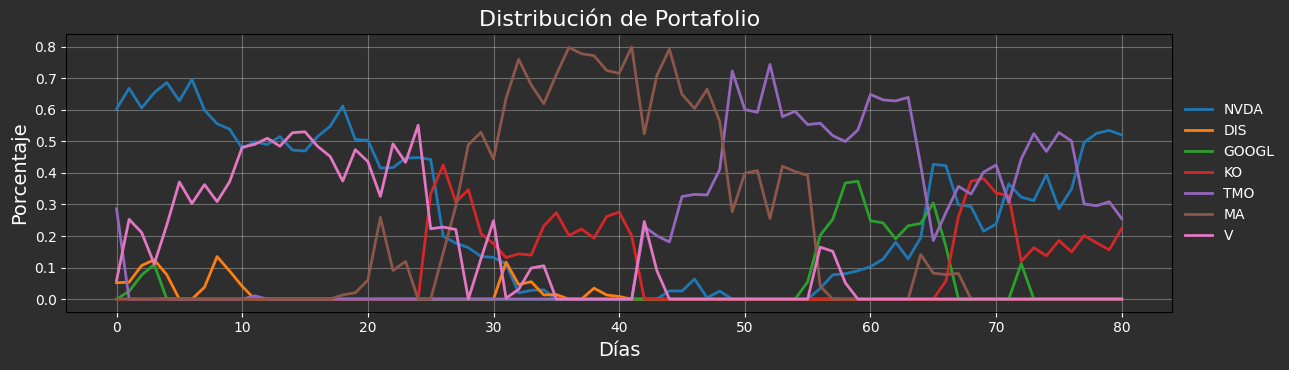

In [ ]:
plott('./data/historical_portfolio_0_40.csv')

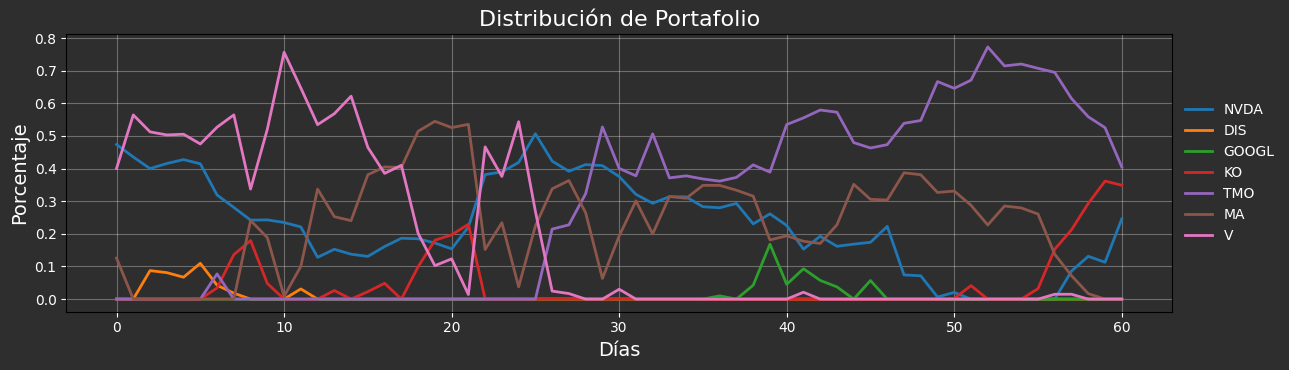

In [ ]:
plott('./data/historical_portfolio_0_60.csv')

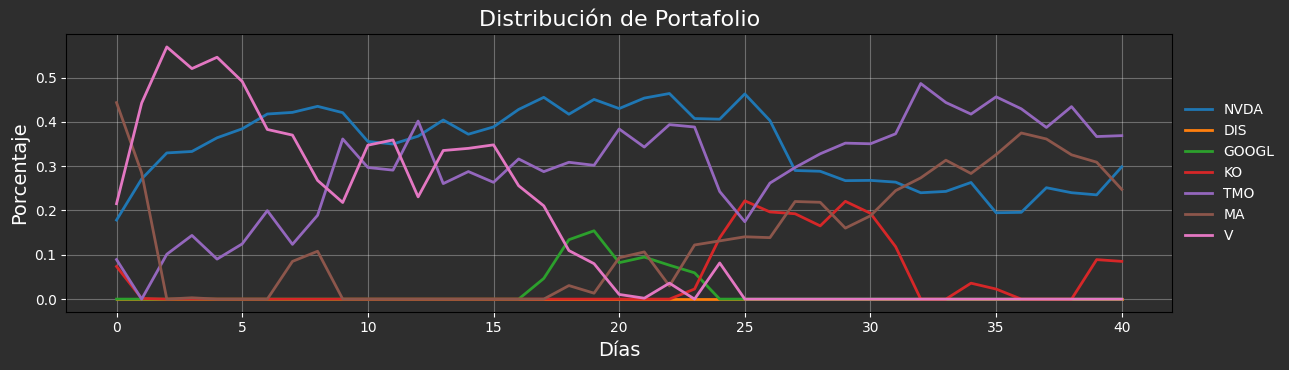

In [ ]:
plott('./data/historical_portfolio_0_80.csv')

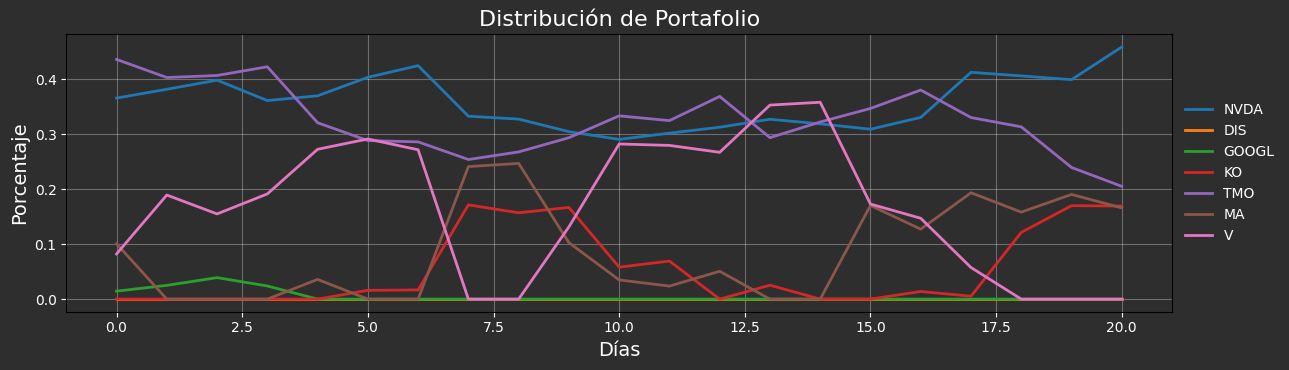

In [ ]:
plott('./data/historical_portfolio_0_100.csv')

In [ ]:
# si creamos 50 combinaciones de siete activos y por el uso del historial solo conseguimos portafolios optimos para los segundos cinco anios tomados esto significa que
# tenemos un total de 208 anios de portafolios de maximo ratio de sharpe

In [ ]:
# despues de tener todos los conjuntos de activos se optimizara el portafolio para cada uno de estos teniendo en cuenta los ultimos cinco anios de datos para cada uno

In [ ]:
# finalmente se prepararan los datos para poder ser procesados por un modelo de prediccion

In [21]:



# Función para generar datos de entrenamiento
def generate_training_data(file_path, window_size=10):
    # Leer el archivo CSV
    df = pd.read_csv(file_path, index_col='Unnamed: 0')
    
    # Convertir el DataFrame a un array de NumPy
    data = df.values

    # Listas para las características y los objetivos
    X, y = [], []

    # Crear ventanas deslizantes
    for i in range(len(data) - window_size):
        # Seleccionar 10 filas como características
        X.append(data[i:i+window_size])
        # Seleccionar la fila 11 (siguiente) como objetivo
        y.append(data[i+window_size])

    # Convertir las listas en arrays de NumPy
    X = np.array(X)
    y = np.array(y)

    return X, y

# Ejemplo de uso
#file_path = "./data/historical_portfolio_0_.csv"
#X, y = generate_training_data(file_path)

#print("Tamaño de X:", X.shape)  # Debería ser (n_samples, 10, n_features)
#print("Tamaño de y:", y.shape)  # Debería ser (n_samples, n_features)



In [ ]:

# Listas para almacenar los resultados combinados
X_all, y_all = [], []

# Procesar cada archivo y combinar los resultados
for i in range(50):
    X, y = generate_training_data(f"./data/historical_portfolio_{i}_.csv")
    X_all.append(X)
    y_all.append(y)

# Concatenar todos los resultados
X_combined = np.concatenate(X_all, axis=0)
y_combined = np.concatenate(y_all, axis=0)

print("Tamaño total de X:", X_combined.shape)  # (n_total_samples, 10, n_features)
print("Tamaño total de y:", y_combined.shape)  # (n_total_samples, n_features)

# guardando
np.savez("./data/combined_training_data.npz", X=X_combined, y=y_combined)



Tamaño total de X: (2050, 10, 7)
Tamaño total de y: (2050, 7)


In [ ]:
# creando una tabla extra que se va a usar como "out-of-sample"

In [28]:



df = asset_data[['AAPL', 'AMZN', 'GOOGL', 'MSFT', 'TSLA', 'NVDA', 'DE']]

df = sr(df)

df.to_csv('./data/out_of_sample.csv')

X, y = generate_training_data('./data/out_of_sample.csv')

print("Tamaño de X:", X.shape)  # Debería ser (n_samples, 10, n_features)
print("Tamaño de y:", y.shape)  # Debería ser (n_samples, n_features)

np.savez("./data/out_of_sample_data.npz", X=X, y=y)



Tamaño de X: (41, 10, 7)
Tamaño de y: (41, 7)


In [ ]:
# no hace falta estandarizando los datos porque ya son todos numeros entre 0 y 1